In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c13c72cfa8152dc2881baaa447157dad522ee26b8fb1806efb34ae36ae0001c8
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
import pandas as pd
torch.set_num_threads(4)


In [ ]:
from sentence_transformers import SentenceTransformer
import torch

# Load the model
model = SentenceTransformer('clip-ViT-B-32')

model.save('clip')


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [ ]:
import shutil

folder_to_zip = 'clip'
shutil.make_archive('clip-model', 'zip', folder_to_zip)


'/content/clip-model.zip'

In [ ]:
from google.colab import files
files.download('clip-model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Upload a folder from your local machine
uploaded = files.upload()


Saving images.zip to images.zip


In [ ]:
print(uploaded)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 6.9 MB/s eta 0:00:00


In [ ]:
pip install "pinecone-client[grpc]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00


In [ ]:
index_name = "clip-sim"

if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)
    print(f"Index '{index_name}' deleted successfully.")
else:
    print(f"Index '{index_name}' does not exist.")

Index 'clip-sim' deleted successfully.


In [ ]:
import pinecone
pinecone.init(
    api_key='1407c226-dc8c-4565-9afa-da62f260b3ae',
    environment='gcp-starter'
)

index_name = "clip-sim"

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
      index_name,
      dimension=512,
      metric="cosine",
      pod_type="s1"
    )


index = pinecone.Index(index_name)

In [ ]:
def load_img_ext_embeddings(zip_file,folder,data_link,emb_filename,use_precomputed_embeddings ):
  img_folder = os.path.join(folder, 'images/images')
  if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
      os.makedirs(img_folder, exist_ok=True)

      if not os.path.exists(zip_file):   #Download dataset if does not exist
          util.http_get(data_link+zip_file, zip_file)


      with zipfile.ZipFile(zip_file, 'r') as zf: #Extract images
          for member in tqdm(zf.infolist(), desc='Extracting'):
              zf.extract(member, img_folder)

  if use_precomputed_embeddings:
      if not os.path.exists(emb_filename):   #Download dataset if does not exist
          util.http_get(data_link+emb_filename, emb_filename)

      with open(emb_filename, 'rb') as fIn:
          img_path, img_emb = pickle.load(fIn)
      print("Images:", len(img_path))
  else:
      img_path= list(glob.glob(img_folder+'/*.jpg'))
      print("Images:", len(img_path))
      img_emb = model.encode([Image.open(filepath) for filepath in img_path], batch_size=100, convert_to_tensor=False, show_progress_bar=True)
  return img_folder,img_path,img_emb

In [ ]:
img_folder,img_path,img_emb=load_img_ext_embeddings('images.zip',"imgs","https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small","product-embeddings.pkl",False)

Images: 44441


Batches:   0%|          | 0/445 [00:00<?, ?it/s]

In [ ]:
img_emb

array([[-0.04967357,  0.2122345 , -0.01326548, ...,  1.3957337 ,
         0.25202137,  0.3671489 ],
       [-0.11804342, -0.47575477,  0.18162233, ...,  0.94460267,
         0.2012021 ,  0.5614292 ],
       [ 0.15373816, -0.1753973 , -0.04843116, ...,  1.1209337 ,
        -0.19523826,  0.74805355],
       ...,
       [-0.19788316, -0.06986291,  0.01144116, ...,  1.2374548 ,
         0.1629545 , -0.2161158 ],
       [-0.16445376,  0.29132122, -0.3881572 , ...,  1.2419077 ,
        -0.00213189,  0.16237134],
       [-0.00224392,  0.06071081,  0.09153105, ...,  1.0258454 ,
         0.32633173,  0.38785526]], dtype=float32)

In [ ]:
data_dict = {'img_path': img_path, 'img_emb': img_emb}

# Specify the file path where you want to save the data
file_path = 'image_data.pkl'

# Serialize and save the data to the file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(data_dict, file)

print(f"Data saved to {file_path}")

Data saved to image_data.pkl


In [ ]:
import pickle
from tqdm import tqdm

# Assuming img_path and img_emb are already loaded with the desired values
# Also assuming that 'index' is a Pinecone index object

# Create a list to store the embeddings and image IDs
data_to_store = []

for path, embedding in tqdm(zip(img_path, img_emb), desc='Inserting embeddings into Pinecone'):
    image_id = os.path.basename(path)  # Extract the image ID from the path


    # Append the image ID and flattened embedding to the list
    data_to_store.append({'image_id': image_id, 'embedding': embedding.tolist()})

data_to_store


In [ ]:
transformed_data = [(entry['image_id'], entry['embedding']) for entry in data_to_store]

print(transformed_data)

In [ ]:
transformed_data

In [ ]:
# Assuming 'index' is a Pinecone index object
# Assuming 'transformed_data' is your list of tuples

# Batching size
batch_size = 100

# Split the data into batches
batches = [transformed_data[i:i + batch_size] for i in range(0, len(transformed_data), batch_size)]

# Upsert each batch
for batch in batches:
    data_to_upsert = [(image_id, embedding) for image_id, embedding in batch]
    index.upsert(data_to_upsert)
    print('completed batch')


completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
completed batch
complete

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loaded_model = SentenceTransformer('/content/drive/MyDrive/clip-model')

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/images


Mounted at /content/drive
/content/drive/MyDrive/images


In [ ]:
import glob

# Count images (adjust the file extension if needed)
image_files = glob.glob('*.jpg') + glob.glob('*.jpeg') + glob.glob('*.png')
num_images = len(image_files)

print(f'Total number of images: {num_images}')

import os

# Count all files
num_files = len([f for f in os.listdir() if os.path.isfile(f)])

print(f'Total number of files: {num_files}')


Total number of images: 5601
Total number of files: 5601


Query:


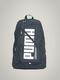

ID: 1525.jpg
Score: 1.00082386


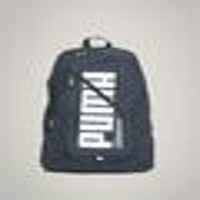

ID: 1697.jpg
Score: 0.906039774


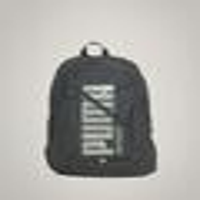

ID: 9580.jpg
Score: 0.863682806


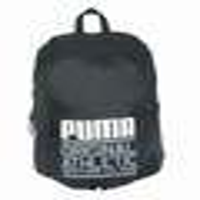

ID: 4680.jpg
Score: 0.830422


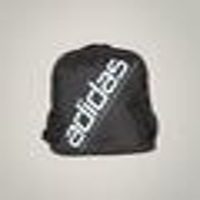

ID: 7119.jpg
Score: 0.817595601


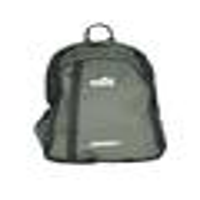

In [ ]:
import numpy as np
from IPython.display import display

img_folder = 'images'

def pinecone_sim_search(query, k=5):
    # Encode the query (img/text) using the model
    query_emb = loaded_model.encode([query], convert_to_tensor=False, show_progress_bar=False)

    # Convert the NumPy array to a Python list
    query_emb_list = query_emb.tolist()

    # Perform a similarity search using Pinecone
    results = index.query(query_emb_list, top_k=k)

    print("Query:")
    display(query)

    # Display information about the top-k matching images
    for result in results['matches']:
        image_id = result['id']
        image_path = os.path.join(img_folder, image_id)
        print("ID:", image_id)
        print("Score:", result['score'])
        display(Image.open(image_path).resize((200, 200)))

# Example usage
query = Image.open(os.path.join(img_folder, '1525.jpg'))  # Replace with your actual query, whether it's an image path or a text description
pinecone_sim_search(query, k=5)


Query:


'shoes'

ID: 4548.jpg
Score: 0.279343665


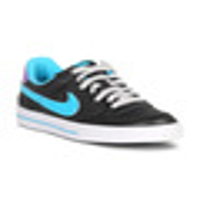

ID: 6799.jpg
Score: 0.276675344


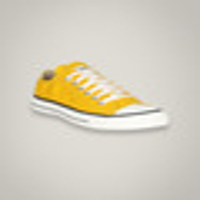

ID: 15715.jpg
Score: 0.276234686


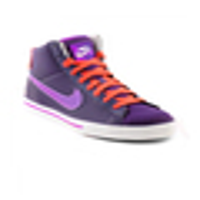

ID: 3183.jpg
Score: 0.276211888


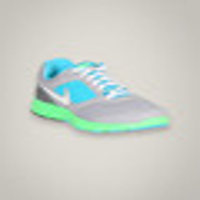

ID: 5471.jpg
Score: 0.274699569


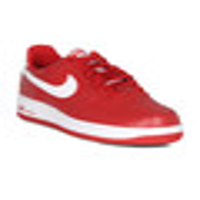

In [ ]:
pinecone_sim_search("shoes")

In [ ]:
def sim_search(query, k=5):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False) ## encode the query(img/text)
    sim_results = util.semantic_search(query_emb, img_emb, top_k=k,corpus_chunk_size=len(img_path)//10,score_function=util.cos_sim)[0] ##util.semantic_search is used to computes the cosine-similarity between query_emb and all img_emb

    print("Query: ")
    display(query)
    for result in sim_results:
        print(img_path[result['corpus_id']])
        display(IPImage(img_path[result['corpus_id']]))


Query: 


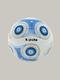

imgs/images/1626.jpg


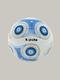

imgs/images/1627.jpg


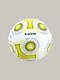

imgs/images/44035.jpg


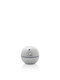

imgs/images/23530.jpg


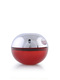

imgs/images/44057.jpg


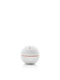

In [ ]:
sim_search(Image.open(os.path.join(img_folder,'1626.jpg')))